2021-11-30 ~ 2023-12-01 까지 2년치 매일 30건씩

주차로 묶어서 시각화

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
sys.path.insert(1, p)
sys.path.insert(1, pp)

In [2]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lib.stats.stats as st
import lib.annotation.Result_Prep as rp
import config.config as conf


In [3]:
path = f'../LLM/result/'
file_list = os.listdir(path)

In [4]:
r_p = rp.Result_Prep()

In [5]:
ver_list = sorted([y for y in [x for x in file_list if x.isdigit()] if (int(y)>=11110000)])

In [6]:
print(ver_list)

['11110000']


In [7]:
tot_calc = pd.DataFrame()
for listid in ver_list:
    df = r_p.make_one_file(listid)
    if isinstance(df, pd.core.frame.DataFrame):
        df = r_p.pp_df(df, 5)
        df = r_p.calc_rate_byweek(df)
        tot_calc = pd.concat([tot_calc, df], axis = 0)

    

In [8]:
tot_calc.tail()

,rel_week,o_result,r_cnt,tot_cnt,rate
313,51.0,1,79,137,57.664234
314,51.0,2,39,137,28.467153
315,52.0,0,28,98,28.571429
316,52.0,1,43,98,43.877551
317,52.0,2,27,98,27.551020


In [9]:
tot_calc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 0 to 317
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rel_week  318 non-null    float64
 1   o_result  318 non-null    object 
 2   r_cnt     318 non-null    int64  
 3   tot_cnt   318 non-null    int64  
 4   rate      318 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 14.9+ KB


In [10]:
m_chk_cnt_0 = tot_calc[tot_calc['o_result'] =='0']
m_chk_cnt_1 = tot_calc[tot_calc['o_result'] =='1']
m_chk_cnt_2 = tot_calc[tot_calc['o_result'] =='2']

In [11]:
m_chk_cnt_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 0 to 315
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rel_week  106 non-null    float64
 1   o_result  106 non-null    object 
 2   r_cnt     106 non-null    int64  
 3   tot_cnt   106 non-null    int64  
 4   rate      106 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 5.0+ KB


In [12]:
print(m_chk_cnt_0.loc[m_chk_cnt_0['o_result'].isna(), 'rate'])
print(m_chk_cnt_1.loc[m_chk_cnt_1['o_result'].isna(), 'rate'])
print(m_chk_cnt_2.loc[m_chk_cnt_2['o_result'].isna(), 'rate'])

Series([], Name: rate, dtype: float64)
Series([], Name: rate, dtype: float64)
Series([], Name: rate, dtype: float64)


In [13]:
m_chk_cnt_0.loc[:, 'o_result'] = '0'
m_chk_cnt_1.loc[:, 'o_result'] = '1'
m_chk_cnt_2.loc[:, 'o_result'] = '2'

In [14]:
m_chk_cnt_0.head()
# m_chk_cnt_2[m_chk_cnt_2['rel_days'].isna()]

,rel_week,o_result,r_cnt,tot_cnt,rate
0,-53.0,0,4,20,20.000000
3,-52.0,0,41,136,30.147059
6,-51.0,0,34,149,22.818792
9,-50.0,0,34,137,24.817518
12,-49.0,0,39,136,28.676471


In [15]:
st_0 = st.Stats(m_chk_cnt_0['rel_week'].values, m_chk_cnt_0['rate'].values, 2, 0.95)
st_1 = st.Stats(m_chk_cnt_1['rel_week'].values, m_chk_cnt_1['rate'].values, 2, 0.95)
st_2 = st.Stats(m_chk_cnt_2['rel_week'].values, m_chk_cnt_2['rate'].values, 2, 0.95)

In [16]:
F_stat_0, p_value_0 = st_0.chow_test()
F_stat_1, p_value_1 = st_1.chow_test()
F_stat_2, p_value_2 = st_2.chow_test()

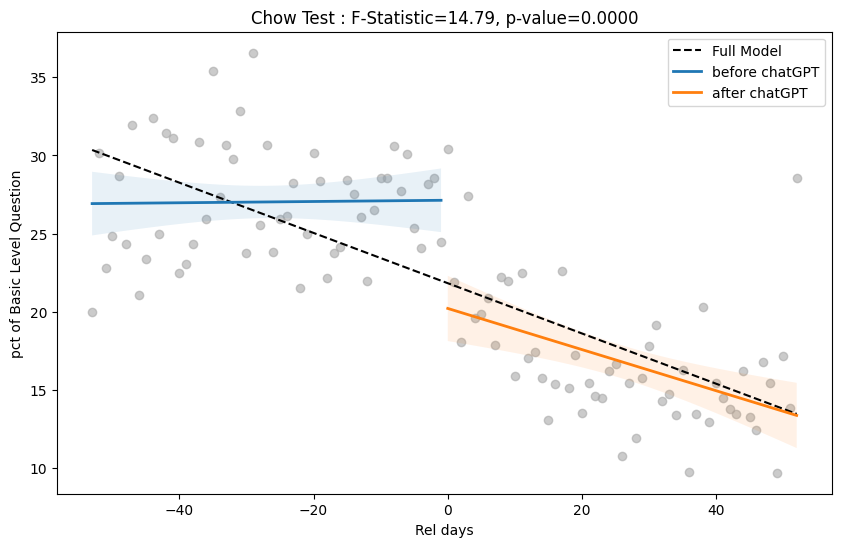

In [17]:
x_0 = m_chk_cnt_0['rel_week'].values
y_0 = m_chk_cnt_0['rate'].values

split_idx = np.argmax(np.where(x_0 < 0))+1
x_0_1= x_0[:split_idx]
x_0_2= x_0[split_idx:]
# 시각화

plt.figure(figsize=(10, 6))
plt.scatter(x_0, y_0,  alpha=0.6, color='darkgray')
plt.plot(x_0, st_0.y_predict, label="Full Model", linestyle="--", color="black")  


plt.plot(x_0_1, st_0.y1_predict, label="before chatGPT", linewidth='2')
plt.fill_between(x_0_1, st_0.y1_predict - st_0.y1_conf_interval, st_0.y1_predict + st_0.y1_conf_interval, alpha=0.1)

plt.plot(x_0_2, st_0.y2_predict, label="after chatGPT", linewidth='2')
plt.fill_between(x_0_2, st_0.y2_predict - st_0.y2_conf_interval, st_0.y2_predict + st_0.y2_conf_interval, alpha=0.1)


plt.legend()
plt.title(f"Chow Test : F-Statistic={F_stat_0:.2f}, p-value={p_value_0:.4f}")
plt.xlabel("Rel days")
plt.ylabel("pct of Basic Level Question")
plt.show()


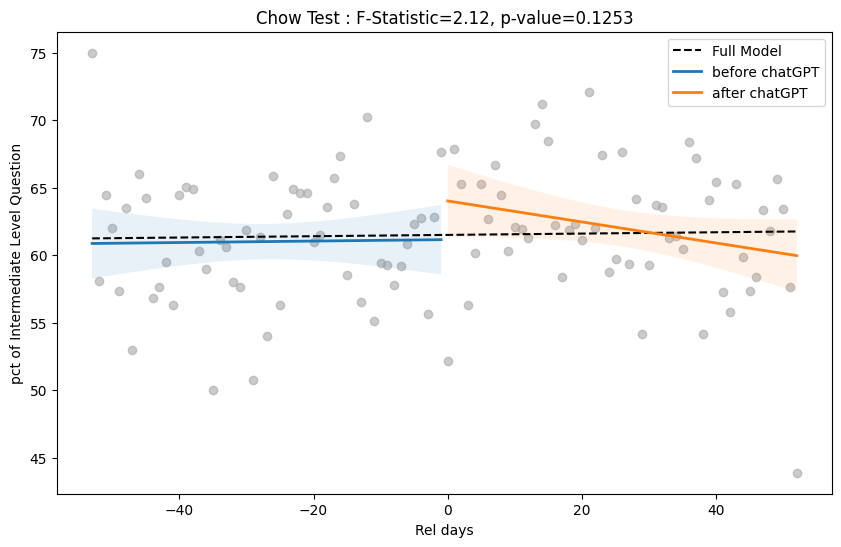

In [18]:
x_1 = m_chk_cnt_1['rel_week'].values
y_1 = m_chk_cnt_1['rate'].values

split_idx = np.argmax(np.where(x_1 < 0))+1
x_1_1 = x_1[:split_idx]
x_1_2 = x_1[split_idx:]
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x_1, y_1,  alpha=0.6, color='darkgray')
plt.plot(x_1, st_1.y_predict, label="Full Model", linestyle="--", color="black")  


plt.plot(x_1_1, st_1.y1_predict, label="before chatGPT", linewidth='2')
plt.fill_between(x_1_1, st_1.y1_predict - st_1.y1_conf_interval, st_1.y1_predict + st_1.y1_conf_interval, alpha=0.1)

plt.plot(x_1_2, st_1.y2_predict, label="after chatGPT", linewidth='2')
plt.fill_between(x_1_2, st_1.y2_predict - st_1.y2_conf_interval, st_1.y2_predict + st_1.y2_conf_interval, alpha=0.1)


plt.legend()
plt.title(f"Chow Test : F-Statistic={F_stat_1:.2f}, p-value={p_value_1:.4f}")
plt.xlabel("Rel days")
plt.ylabel("pct of Intermediate Level Question")
plt.show()


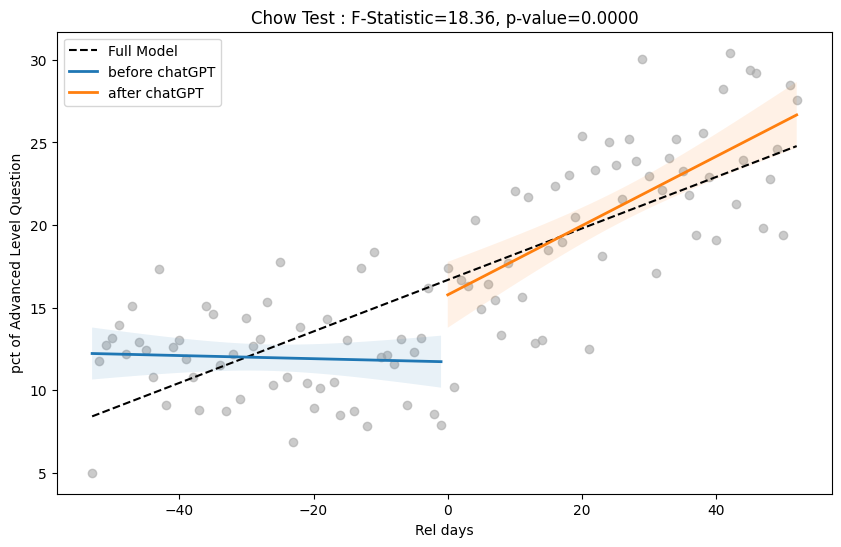

In [19]:
x_2 = m_chk_cnt_2['rel_week'].values
y_2 = m_chk_cnt_2['rate'].values

split_idx = np.argmax(np.where(x_2 < 0))+1
x_2_1 = x_2[:split_idx]
x_2_2 = x_2[split_idx:]
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x_2, y_2,  alpha=0.6, color='darkgray')
plt.plot(x_2, st_2.y_predict, label="Full Model", linestyle="--", color="black")  


plt.plot(x_2_1, st_2.y1_predict, label="before chatGPT", linewidth='2')
plt.fill_between(x_2_1, st_2.y1_predict - st_2.y1_conf_interval, st_2.y1_predict + st_2.y1_conf_interval, alpha=0.1)

plt.plot(x_2_2, st_2.y2_predict, label="after chatGPT", linewidth='2')
plt.fill_between(x_2_2, st_2.y2_predict - st_2.y2_conf_interval, st_2.y2_predict + st_2.y2_conf_interval, alpha=0.1)


plt.legend()
plt.title(f"Chow Test : F-Statistic={F_stat_2:.2f}, p-value={p_value_2:.4f}")
plt.xlabel("Rel days")
plt.ylabel("pct of Advanced Level Question")
plt.show()


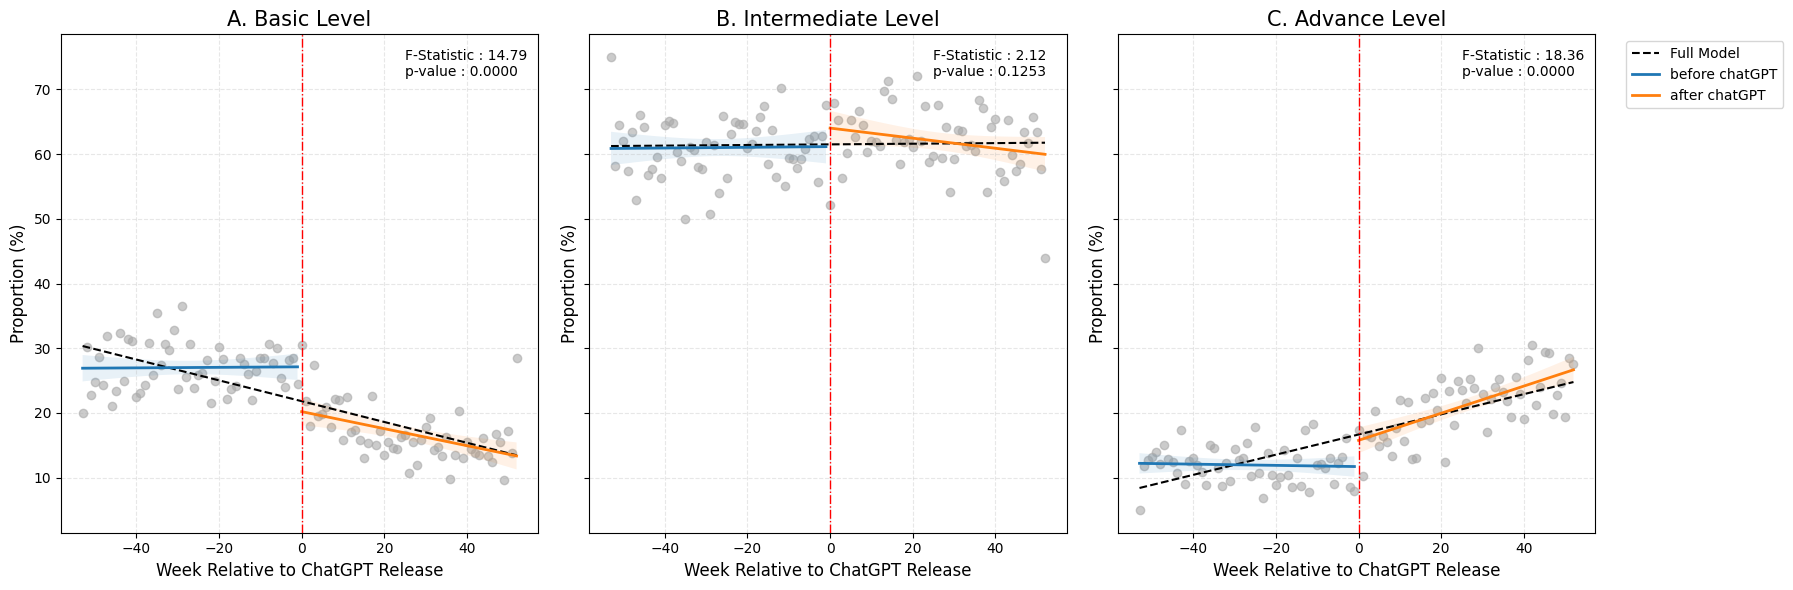

In [ ]:
### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 3, figsize = (18, 6), sharey=sharey, sharex=sharex)


axs[0].scatter(x_0, y_0,  alpha=0.6, color='darkgray')
axs[0].plot(x_0, st_0.y_predict, label="Full Model", linestyle="--", color="black")  
axs[0].plot(x_0_1, st_0.y1_predict, label="before chatGPT", linewidth='2')
axs[0].fill_between(x_0_1, st_0.y1_predict - st_0.y1_conf_interval, st_0.y1_predict + st_0.y1_conf_interval, alpha=0.1)
axs[0].plot(x_0_2, st_0.y2_predict, label="after chatGPT", linewidth='2')
axs[0].fill_between(x_0_2, st_0.y2_predict - st_0.y2_conf_interval, st_0.y2_predict + st_0.y2_conf_interval, alpha=0.1)
axs[0].axvline(x=0,     color='red',    linestyle='-.', linewidth=1)
axs[0].set_title(f"Basic Level", fontsize=15)
axs[0].set_xlabel("Week Relative to ChatGPT Release", fontsize=12)
axs[0].set_ylabel("Proportion (%)", fontsize=12)
axs[0].text(25, 72,s=f'F-Statistic : {F_stat_0:.2f}\np-value : {p_value_0:.4f}', fontsize = 10) 
axs[0].grid(True, linestyle='--', alpha=0.3)


axs[1].scatter(x_1, y_1,  alpha=0.6, color='darkgray')
axs[1].plot(x_1, st_1.y_predict, label="Full Model", linestyle="--", color="black")  
axs[1].plot(x_1_1, st_1.y1_predict, label="before chatGPT", linewidth='2')
axs[1].fill_between(x_1_1, st_1.y1_predict - st_1.y1_conf_interval, st_1.y1_predict + st_1.y1_conf_interval, alpha=0.1)
axs[1].plot(x_1_2, st_1.y2_predict, label="after chatGPT", linewidth='2')
axs[1].fill_between(x_1_2, st_1.y2_predict - st_1.y2_conf_interval, st_1.y2_predict + st_1.y2_conf_interval, alpha=0.1)
axs[1].axvline(x=0,     color='red',    linestyle='-.', linewidth=1)
axs[1].set_title(f"Intermediate Level", fontsize=15)
axs[1].set_xlabel("Week Relative to ChatGPT Release", fontsize=12)
axs[1].set_ylabel("Proportion (%)", fontsize=12)
axs[1].grid(False)
axs[1].text(25, 72, s=f'F-Statistic : {F_stat_1:.2f}\np-value : {p_value_1:.4f}', fontsize = 10) 
axs[1].grid(True, linestyle='--', alpha=0.3)

axs[2].scatter(x_2, y_2,  alpha=0.6, color='darkgray')
axs[2].plot(x_2, st_2.y_predict, label="Full Model", linestyle="--", color="black")  
axs[2].plot(x_2_1, st_2.y1_predict, label="before chatGPT", linewidth='2')
axs[2].fill_between(x_2_1, st_2.y1_predict - st_2.y1_conf_interval, st_2.y1_predict + st_2.y1_conf_interval, alpha=0.1)
axs[2].plot(x_2_2, st_2.y2_predict, label="after chatGPT", linewidth='2')
axs[2].fill_between(x_2_2, st_2.y2_predict - st_2.y2_conf_interval, st_2.y2_predict + st_2.y2_conf_interval, alpha=0.1)
axs[2].axvline(x=0,     color='red',    linestyle='-.', linewidth=1)
axs[2].set_title(f"Advance Level", fontsize=15)
axs[2].set_xlabel("Week Relative to ChatGPT Release", fontsize=12)
axs[2].set_ylabel("Proportion (%)", fontsize=12)
axs[2].text(25, 72, s=f'F-Statistic : {F_stat_2:.2f}\np-value : {p_value_2:.4f}', fontsize = 10) 
axs[2].grid(True, linestyle='--', alpha=0.3)

# plt.suptitle("Structural Change of Difficulty Proportion around ChatGPT release",fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
fig.savefig("./fig/Result_Fig1.png", dpi=300, bbox_inches='tight')  # DPI 설정 및 여백 최소화
plt.show();